# Проект: Идентификация типа почвы по фотографии и рекомендация наиболее подходящей культяры для засева

In [2]:
# %pip install catboost

In [24]:
import os
import shutil
import random
from tqdm import tqdm

from PIL import Image
from PIL import Image, ImageOps

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score

from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from datasets import load_dataset

import matplotlib.pyplot as plt

from catboost import CatBoostClassifier

 ### Обработка сырых данных
 1) Клонируем репозиторий с фотографиями почв и метками типов
 2) Приводим изображения к размеру 224 на 224 и обращаем в тензоры, упаковываем в torchvision датасет

In [1]:
!git clone https://github.com/Phantom-fs/Soil-Classification-Dataset.git

Cloning into 'Soil-Classification-Dataset'...
remote: Enumerating objects: 5066, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5066 (delta 0), reused 0 (delta 0), pack-reused 5063 (from 2)
Receiving objects: 100% (5066/5066), 259.45 MiB | 24.57 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (6288/6288), done.


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])

dataset = datasets.ImageFolder(root = "/content/Soil-Classification-Dataset/Orignal-Dataset")


In [4]:
print(f"Classes: {dataset.classes}")
print(f"Data entries: {len(dataset)}")

Classes: ['Alluvial_Soil', 'Arid_Soil', 'Black_Soil', 'Laterite_Soil', 'Mountain_Soil', 'Red_Soil', 'Yellow_Soil']
Data entries: 1189


7 классов почв, 1189 наблюдений

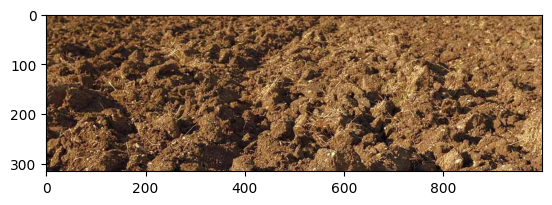

In [5]:

plt.imshow(dataset[0][0])

### Дообучение модели
1) Разделим выборку train-test 80 на 20
2) Дообучим модель на 10 эпохах с размером батча 32

In [9]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

In [10]:
# Мэппинг между id и названиями классов и vice verse
num_labels = len(dataset.classes)
id_label_map = {i: c for i, c in enumerate(dataset.classes)}
label_id_map = {c: i for i, c in enumerate(dataset.classes)}

Возьмем готовую модель "microsoft/resnet-50" и дадим ей мэппинг между id и названием классов (видов почв)

In [13]:
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-50",
                                                     num_labels=num_labels,
                                                         id2label=id_label_map,

    label2id=label_id_map,
                                                        ignore_mismatched_sizes=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([7, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Функция для сбора батча
def collate_fn(batch):
    images = [x[0] for x in batch]
    labels = torch.tensor([x[1] for x in batch], dtype=torch.long)
    inputs = processor(images=images, return_tensors="pt")
    inputs["labels"] = labels
    return inputs

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [15]:
import torch.nn.functional as F
from torch.optim import AdamW

# Выбираем вид памяти
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()

#Задаем параметры модели
opt = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

epochs = 15 # количество эпох обучения

for epoch in range(epochs):
    total_loss = 0.0
    correct = 0
    n = 0

    #Пройдемся по нашим батчам
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        out = model(**batch)
        loss = out.loss

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        total_loss += loss.item() * batch["labels"].size(0)

        preds = out.logits.argmax(dim=-1)
        correct += (preds == batch["labels"]).sum().item()
        n += batch["labels"].size(0)

    print(f"epoch {epoch+1}: loss={total_loss/n:.4f} acc={correct/n:.4f}")


epoch 1: loss=1.9333 acc=0.1723
epoch 2: loss=1.8962 acc=0.2668
epoch 3: loss=1.8617 acc=0.3498
epoch 4: loss=1.8282 acc=0.4349
epoch 5: loss=1.7927 acc=0.4853
epoch 6: loss=1.7589 acc=0.5074
epoch 7: loss=1.7187 acc=0.5168
epoch 8: loss=1.6795 acc=0.5578
epoch 9: loss=1.6395 acc=0.5924
epoch 10: loss=1.5925 acc=0.6061
epoch 11: loss=1.5419 acc=0.6292
epoch 12: loss=1.4897 acc=0.6334
epoch 13: loss=1.4327 acc=0.6534
epoch 14: loss=1.3872 acc=0.6586
epoch 15: loss=1.3303 acc=0.6660


In [17]:
model.eval()


ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

Получим предсказания классов нашей нейронной сети для тестового датасета test_dataset

In [18]:
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

all_preds = []

with torch.inference_mode():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        logits = model(**batch).logits
        probs = torch.softmax(logits, dim=-1)

        preds = probs.argmax(dim=-1)

        all_preds.append(preds.cpu())

all_preds = torch.cat(all_preds)

Переведем id классов в лейблы

In [30]:
pred_labels_test = [id_label_map[i] for i in all_preds.tolist()]
df_labels_test_pred = pd.DataFrame(pred_labels_test)
df_labels_test_pred.to_csv('labels_soils_test_pred.csv')

In [31]:
df_labels_test_pred

,0
0,Arid_Soil
1,Arid_Soil
2,Laterite_Soil
3,Arid_Soil
4,Mountain_Soil
...,...
232,Arid_Soil
233,Arid_Soil
234,Arid_Soil
235,Black_Soil


In [28]:
test_list_labels = []
for i in range(len(test_dataset)):
  test_list_labels.append(id_label_map[dataset[i][1]])

df_labels_test = pd.DataFrame(test_list_labels)
df_labels_test.to_csv('labels_soils_test.csv')

In [27]:
# Сохраним csv с лейблами (названиями) типов почв в изначальном датасете (на основе него сгенерируем другой датасет для прототипа рекомендательной системв)
list_labels = []
for i in range(len(dataset)):
  list_labels.append(id_label_map[dataset[i][1]])

df_labels = pd.DataFrame(list_labels)
df_labels.to_csv('labels_soils.csv')

In [39]:
acc_model = accuracy_score(df_labels_test, df_labels_test_pred)
print(f'Модель предсказывает класс почвы верно с вероятностью {acc_model*100:.2f}%')

Модель предсказывает класс почвы верно с вероятностью 23.21%


### Сделаем прототип продуктовой части будущей рекомендательной системы
1) Сгенерируем набор данных под имеющиеся у нас фотографии (1189 сэмплов) с описаниями климатических условий по местности/химическим составом почвы/композицией и оптимальной "рекомендацией" вида растения которое лучше всего приживалось в таких условиях
2) По набору данных обучим классификатор CatBoost который по физическим характеристикам окружающей среды/химическому составу почвы будет отдавать лучшее предсказание и перечень вероятностей
3) Реализуем протитип выдачи рекомендации пользователю по входныv данным

In [5]:
df_X_y = pd.read_csv('synthetic_soil_climate_crop_dataset.csv')

In [6]:
df_X_y.columns

Index(['soil_label', 'climate_zone', 'temp_c_mean', 'rain_mm_year',
       'rel_humidity_pct', 'ph', 'organic_carbon_pct', 'n_kg_ha', 'p_kg_ha',
       'k_kg_ha', 'cec_cmol_kg', 'ec_ds_m', 'soil_moisture_pct', 'sand_pct',
       'silt_pct', 'clay_pct', 'recommended_crop'],
      dtype='object')

In [7]:
X = df_X_y[['soil_label', 'climate_zone', 'temp_c_mean', 'rain_mm_year',
       'rel_humidity_pct', 'ph', 'organic_carbon_pct', 'n_kg_ha', 'p_kg_ha',
       'k_kg_ha', 'cec_cmol_kg', 'ec_ds_m', 'soil_moisture_pct', 'sand_pct',
       'silt_pct', 'clay_pct']]
y = df_X_y['recommended_crop']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Обучим сразу 3 конфигурации модели, чтобы иметь возможность рекомендовать растения для посадки по неполному инпуту от пользователя

In [9]:
m1_params = ['soil_label', 'climate_zone']
m2_params = ['soil_label', 'climate_zone', 'temp_c_mean', 'rain_mm_year',
       'rel_humidity_pct']
m3_params = ['soil_label', 'climate_zone', 'temp_c_mean', 'rain_mm_year',
       'rel_humidity_pct','ph', 'organic_carbon_pct', 'n_kg_ha', 'p_kg_ha',
       'k_kg_ha', 'cec_cmol_kg', 'ec_ds_m', 'soil_moisture_pct', 'sand_pct',
       'silt_pct', 'clay_pct']

cat_cols = ['soil_label', 'climate_zone']
cat_idx = [idx for idx, el in enumerate(m1_params) if el in cat_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
def make_catboost_model():
    return CatBoostClassifier(
        iterations=400,
        learning_rate=0.05,
        depth=8,
        loss_function="MultiClass",
        eval_metric="MultiClass",
        verbose=100
    )
m1= make_catboost_model()
m2 = make_catboost_model()
m3 = make_catboost_model()

m1.fit(X_train[m1_params], y_train, cat_features=cat_idx)
m2.fit(X_train[m2_params], y_train, cat_features=cat_idx)
m3.fit(X_train[m3_params], y_train, cat_features=cat_idx)
# pred = model.predict(X_test)

0:	learn: 3.3335113	total: 1.35s	remaining: 9m
100:	learn: 1.7434267	total: 59.1s	remaining: 2m 55s
200:	learn: 1.5001255	total: 2m 7s	remaining: 2m 5s
300:	learn: 1.3428132	total: 3m 14s	remaining: 1m 3s
399:	learn: 1.2227237	total: 4m 31s	remaining: 0us
0:	learn: 3.3621464	total: 1.34s	remaining: 8m 54s
100:	learn: 1.7351181	total: 1m 25s	remaining: 4m 12s
200:	learn: 1.4296432	total: 2m 39s	remaining: 2m 37s
300:	learn: 1.1754902	total: 4m 6s	remaining: 1m 21s
399:	learn: 0.9920898	total: 5m 29s	remaining: 0us
0:	learn: 3.3298354	total: 560ms	remaining: 3m 43s
100:	learn: 1.6306869	total: 1m 35s	remaining: 4m 42s
200:	learn: 1.1969976	total: 3m 21s	remaining: 3m 19s
300:	learn: 0.8836345	total: 5m 7s	remaining: 1m 41s
399:	learn: 0.6769065	total: 6m 52s	remaining: 0us


Зададим условия для выбора той или иной конфигурации модели по формату ввода параметров пользователем:
1) **Минимальный набор**: Указан только тип почвы (предсказали по фотографии загруженной пользвоателем) + указана примерная климатическая зона в которой планируется посев
2) **Средний набор**: Все из пункта 1) + имеем детальное представление от пользователя о климатических условиях на его участке (либо по историческим данным от метеослужб по координатам при разрешении сбора данных по геолокации пользователя/либо пользователь собственноручно укажет параметры)
3) **Максимальный набор**: Все из пункта 2) + параметры минерализации/физические характеристики почвы указанные пользователем

In [10]:
def pick_model_from_user_inputs_and_predict(proba = False, **kwargs):
  # Проверяем указал ли пользователь правильно все именованные параметры
  if any(k not in ['soil_label','climate_zone', 'temp_c_mean', 'rain_mm_year',
       'rel_humidity_pct', 'ph', 'organic_carbon_pct', 'n_kg_ha', 'p_kg_ha',
       'k_kg_ha', 'cec_cmol_kg', 'ec_ds_m', 'soil_moisture_pct', 'sand_pct',
       'silt_pct', 'clay_pct'] for k in kwargs.keys()):
    raise 'Указаны неверные параметры климата/характеристик почвы'

  #Проверяем какую модель отдадим пользователям по вводным
  def get_model_given_inputs(**kwargs):
    if all(k in m1_params for k in kwargs.keys()):
      print('proceed_with_light_model')
      return m1
    elif all(k in m2_params for k in kwargs.keys()):
      print('proceed_with_climate_informed_model')
      return m2
    elif all(k in m3_params for k in kwargs.keys()):
      print('proceed_with_climate_soil_details_model')
      return m3
    else:
      raise 'Указан неполный набор параметров'

  #Решаем что выводить: вероятности классов или 1 лучшее предстказание
  X = pd.DataFrame(dict(zip(kwargs.keys(), map(lambda x: [x], kwargs.values()))))
  if not proba:
    return get_model_given_inputs(**kwargs).predict(X)
  else:
    classes = list(get_model_given_inputs(**kwargs).classes_)
    probas = list(get_model_given_inputs(**kwargs).predict_proba(X)[0])
    return dict(zip(classes, probas))

Сделаем датафрейм из топ k рекомендаций по значению вероятности предсказания класса от catBoost

In [16]:
def top_k_crops_df(dict_crops, k = 5):
  df_crops = pd.DataFrame({'crop': dict_crops.keys(),
  'proba':dict_crops.values()})
  df_crops.sort_values(by = 'proba', ascending = False, inplace = True)
  return df_crops.head(k)

In [12]:
pick_model_from_user_inputs_and_predict(proba = False, soil_label = 'Arid_Soil', climate_zone = 'Tropical')

proceed_with_light_model


array([['chickpea']], dtype=object)

In [13]:
pick_model_from_user_inputs_and_predict(proba = True, soil_label = 'Arid_Soil', climate_zone = 'Tropical')

proceed_with_light_model
proceed_with_light_model


{'apple': np.float64(0.002176334304589791),
 'banana': np.float64(0.0014455595184959633),
 'barley': np.float64(0.23758753378466327),
 'buckwheat': np.float64(0.0021658337921645725),
 'cactus_fruit': np.float64(0.05643250833483772),
 'cashew': np.float64(0.007159049328485516),
 'cassava': np.float64(0.0069245315218847536),
 'chickpea': np.float64(0.2580334644111366),
 'coffee': np.float64(0.011295315503039105),
 'cotton': np.float64(0.001488959711354829),
 'date_palm': np.float64(0.0797673539120814),
 'ginger': np.float64(0.0012698064469647081),
 'groundnut': np.float64(0.0017555637466361942),
 'maize': np.float64(0.0023773806617095393),
 'millet': np.float64(0.11616745972604176),
 'peas': np.float64(0.0021295210295721686),
 'pigeon_pea': np.float64(0.0018090466880224352),
 'pineapple': np.float64(0.009861376635574032),
 'potato': np.float64(0.0021906780604457735),
 'rice': np.float64(0.0014237067663099338),
 'rubber': np.float64(0.009248097742619194),
 'sorghum': np.float64(0.16140397

In [14]:
proba_crops = pick_model_from_user_inputs_and_predict(proba = True, soil_label = 'Arid_Soil', climate_zone = 'Tropical')

proceed_with_light_model
proceed_with_light_model


In [17]:
top_k_crops_df(proba_crops)

,crop,proba
7,chickpea,0.258033
2,barley,0.237588
21,sorghum,0.161404
14,millet,0.116167
10,date_palm,0.079767


In [18]:
# Подготовим фотографии растений из рекомендательной выдачи к отображению на графике (ресайз)
def prepare_image(path, size=80):
    img = Image.open(path).convert("RGB")
    img = ImageOps.contain(img, (size, size))
    bg = Image.new("RGB", (size, size), (255, 255, 255))
    bg.paste(img, ((size - img.size[0]) // 2,
                   (size - img.size[1]) // 2))
    return bg

In [19]:
# Запишем функцию для отрисовки графика: фотография + вероятность рекомендации
def plot_simple_recommendations(
    topk_df,
    image_dir="crop_images",
    img_size=80,
    title="Топ-5 рекомендаций"
):
    # Берем список растений и вероятностей
    crops = topk_df["crop"].tolist()
    probs = (topk_df["proba"] * 100).round(1).tolist()

    fig, axes = plt.subplots(
        len(crops), 1,
        figsize=(8, 1.2 * len(crops))
    )

    if len(crops) == 1:
        axes = [axes]

    for ax, crop, prob in zip(axes, crops, probs):
        ax.axis("off")

        # Грузим и приводим фотки к одному сайзу
        img_path = os.path.join(image_dir, f"{crop}.jpg")
        if os.path.exists(img_path):
            img = prepare_image(img_path, img_size)
            ax.imshow(img, extent=(0, 1, 0, 1))
        else:
            ax.text(0.05, 0.5, "no image", va="center")

        ax.text(
            1.2, 0.5,
            crop.replace("_", " "),
            va="center",
            ha="left",
            fontsize=12,
            weight="bold"
        )

        #Отпечатываем вероятность предстказания
        ax.text(
            3.8, 0.5,
            f"{prob} %",
            va="center",
            ha="right",
            fontsize=12
        )

        ax.set_xlim(0, 4)
        ax.set_ylim(0, 1)

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


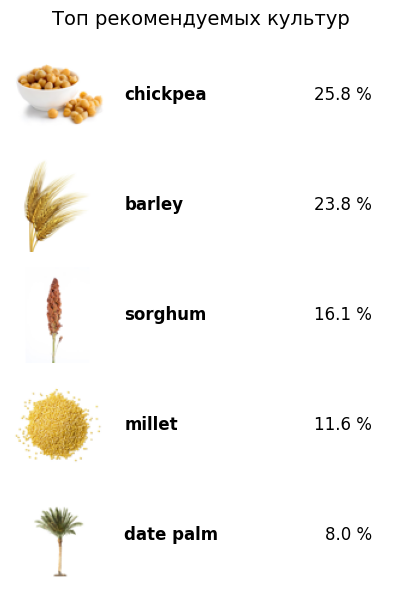

In [25]:
plot_simple_recommendations(
    top_k_crops_df(proba_crops),
    image_dir="crop_images",
    title="Топ рекомендуемых культур"
)